In [7]:
import yfinance as yf
from fredapi import Fred
from config import get_fredapi_key

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# define fred api (using my personal api key)
fred = Fred(api_key = get_fredapi_key())

# Data Acquision

- SP500: https://finance.yahoo.com/quote/%5EGSPC/
- MY10Y: https://fred.stlouisfed.org/series/DGS10
- CPI: https://fred.stlouisfed.org/series/CPIAUCSL
- M2SL: https://fred.stlouisfed.org/series/M2SL
- CSENT: https://fred.stlouisfed.org/series/UMCSENT
- IPM: https://fred.stlouisfed.org/series/IPMAN
- UNEMP: https://fred.stlouisfed.org/series/UNRATE

In [8]:
# Run the following code to get all data from the web.

"""

# define data
df_origin = pd.DataFrame()

### Data from yahoo finance
# download data as ticker "^GSPC" and convert to monthly data
sp500 = yf.download(['^GSPC'], start='1950-01-01').resample('M').last().reset_index()

# add "Date" (format: yyyy-mm) column to "df"
df_origin['Date'] = sp500['Date'].dt.strftime('%Y-%m')

# create new columns: "Year" and "Month" and add them to "df"
df_origin['Year'] = sp500['Date'].dt.year
df_origin['Month'] = sp500['Date'].dt.month

# add S&P500 data
df_origin['SP500'] = sp500['Close']

# calculate % change of YoY
#df_origin['SP500_%YoY'] = df_origin['SP500'].pct_change(12)


### Data from Fred
# list of ids and column names of monthly data
ids = ['DGS10', 'CPIAUCSL', 'UMCSENT', 'IPMAN', 'HSN1F', 'UNRATE']
cols = ['MY10Y', 'CPI', 'CSENT', 'IPM', 'HOUSE', 'UNEMP']

# travering all pairs of ids and cols
for id, col in zip(ids, cols):
    # get the original data
    original = fred.get_series(id)
    # convert current index to column & change monthly data
    df_merge = original.resample('M').last().reset_index()
    # change column names
    df_merge.columns = ['Date', col]
    # update format of 'Date' column
    df_merge['Date'] = df_merge['Date'].dt.strftime('%Y-%m')

    # if column is not "UNEMP", add growth percentage
    #if col != 'UNEMP':
    #    df_merge[f'{col}_%YoY'] = df_merge[col].pct_change(12)

    # merge two data frames
    df_origin = pd.merge(df_origin, df_merge, on='Date', how='left') # type: ignore

# download the original dataframe as csv
df_origin.to_csv('original.csv', index=False)

# show the first 5 rows
df_origin.head()

"""

'\n\n# define data\ndf_origin = pd.DataFrame()\n\n### Data from yahoo finance\n# download data as ticker "^GSPC" and convert to monthly data\nsp500 = yf.download([\'^GSPC\'], start=\'1950-01-01\').resample(\'M\').last().reset_index()\n\n# add "Date" (format: yyyy-mm) column to "df"\ndf_origin[\'Date\'] = sp500[\'Date\'].dt.strftime(\'%Y-%m\')\n\n# create new columns: "Year" and "Month" and add them to "df"\ndf_origin[\'Year\'] = sp500[\'Date\'].dt.year\ndf_origin[\'Month\'] = sp500[\'Date\'].dt.month\n\n# add S&P500 data\ndf_origin[\'SP500\'] = sp500[\'Close\']\n\n# calculate % change of YoY\n#df_origin[\'SP500_%YoY\'] = df_origin[\'SP500\'].pct_change(12)\n\n\n### Data from Fred\n# list of ids and column names of monthly data\nids = [\'DGS10\', \'CPIAUCSL\', \'UMCSENT\', \'IPMAN\', \'HSN1F\', \'UNRATE\']\ncols = [\'MY10Y\', \'CPI\', \'CSENT\', \'IPM\', \'HOUSE\', \'UNEMP\']\n\n# travering all pairs of ids and cols\nfor id, col in zip(ids, cols):\n    # get the original data\n    origi

In [9]:
# get original data from local file
df_origin = pd.read_csv('original.csv')
df_origin.head()

,Date,Year,Month,SP500,MY10Y,CPI,CSENT,IPM,HOUSE,UNEMP
0,1950-01,1950,1,17.049999,NaN,23.51,NaN,NaN,NaN,6.5
1,1950-02,1950,2,17.219999,NaN,23.61,NaN,NaN,NaN,6.4
2,1950-03,1950,3,17.290001,NaN,23.64,NaN,NaN,NaN,6.3
3,1950-04,1950,4,17.959999,NaN,23.65,NaN,NaN,NaN,5.8
4,1950-05,1950,5,18.780001,NaN,23.77,NaN,NaN,NaN,5.5


# Data Clearning & Modification

In [10]:
# dropping rows based on any missing data
df = df_origin.dropna()

# groupby dataframe based on "Year" and check the count
df.groupby('Year').count()[['Date']]

,Date
Year,
1972,4
1973,4
1974,4
1975,4
1976,4
1977,4
1978,12
1979,12
1980,12


In [11]:
# Based on the observation, the data between 1973 and 1977 has missing in some months.
# Thus, removing data between 1973 and 1977.
df = df[df['Year'] >= 1978].reset_index(drop=True)
df.head()

,Date,Year,Month,SP500,MY10Y,CPI,CSENT,IPM,HOUSE,UNEMP
0,1978-01,1978,1,89.250000,7.94,62.7,83.7,43.7471,795.0,6.4
1,1978-02,1978,2,87.040001,8.04,63.0,84.3,43.9139,791.0,6.3
2,1978-03,1978,3,89.209999,8.15,63.4,78.8,44.6899,814.0,6.3
3,1978-04,1978,4,96.830002,8.24,63.9,81.6,45.3905,864.0,6.1
4,1978-05,1978,5,97.239998,8.42,64.5,82.9,45.6235,857.0,6.0


In [12]:
# Changes to %YoY
num_cols = ['SP500', 'MY10Y', 'CPI', 'CSENT', 'IPM', 'HOUSE', 'UNEMP']
df[num_cols] = df[num_cols].pct_change(12)

# drop the rows with missing values
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

df.head()

,Date,Year,Month,SP500,MY10Y,CPI,CSENT,IPM,HOUSE,UNEMP
0,1979-01,1979,1,0.119664,0.127204,0.092504,-0.138590,0.078625,-0.051572,-0.078125
1,1979-02,1979,2,0.106158,0.140547,0.098413,-0.123369,0.077868,-0.085967,-0.063492
2,1979-03,1979,3,0.138774,0.117791,0.102524,-0.131980,0.064187,-0.025799,-0.079365
3,1979-04,1979,4,0.050914,0.134709,0.104851,-0.191176,0.029980,-0.134259,-0.049180
4,1979-05,1979,5,0.018922,0.076010,0.106977,-0.178528,0.039179,-0.151692,-0.066667


In [13]:
# comparisons between original and cleaned data
print('Dimensions:')
print(df_origin.shape, ' -> ', df.shape)
print('')
print('Total Missing Valies:')
print(df_origin.isna().sum().sum(), ' -> ', df.isna().sum().sum())

Dimensions:
(885, 10)  ->  (536, 10)

Total Missing Valies:
813  ->  0


In [14]:
# basic statistics (original)
df_origin[num_cols].describe()

,SP500,MY10Y,CPI,CSENT,IPM,HOUSE,UNEMP
count,885.000000,741.000000,884.000000,640.000000,620.000000,728.000000,884.000000
mean,772.934463,5.876100,122.063393,85.612031,74.204909,655.686813,5.735860
std,1028.041579,2.994174,83.545351,12.870315,23.716954,208.464177,1.711136
min,17.049999,0.550000,23.510000,50.000000,35.254500,270.000000,2.500000
25%,88.750000,3.850000,34.650000,76.100000,50.362625,515.000000,4.475000
50%,247.350006,5.640000,110.300000,89.300000,81.475050,628.000000,5.500000
75%,1211.229980,7.640000,193.225000,95.000000,98.332150,765.250000,6.800000
max,4766.180176,15.840000,306.269000,112.000000,106.420200,1389.000000,14.700000


In [15]:
# basic statistics (current)
df[num_cols].describe()

,SP500,MY10Y,CPI,CSENT,IPM,HOUSE,UNEMP
count,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000
mean,0.100368,0.027759,0.035218,0.003980,0.018915,0.014824,0.015936
std,0.159240,0.332175,0.027606,0.134958,0.049064,0.199572,0.296356
min,-0.447562,-0.745020,-0.019588,-0.415205,-0.195131,-0.505348,-0.585034
25%,0.020400,-0.157653,0.018967,-0.066028,-0.002180,-0.109084,-0.104288
50%,0.116480,-0.030445,0.028427,0.002501,0.023580,0.027042,-0.054054
75%,0.196480,0.141276,0.041295,0.066968,0.047264,0.135710,0.051814
max,0.537145,1.645161,0.145923,0.475822,0.208198,0.882006,3.083333


# Data Observation

### Correlation Matrix

In [16]:
# correlation Matrix
df[num_cols].corr()

,SP500,MY10Y,CPI,CSENT,IPM,HOUSE,UNEMP
SP500,1.000000,0.084013,-0.020042,0.418819,0.398670,0.378325,-0.226288
MY10Y,0.084013,1.000000,0.360712,0.037577,0.259214,-0.258088,-0.390667
CPI,-0.020042,0.360712,1.000000,-0.230014,0.023860,-0.362648,-0.094675
CSENT,0.418819,0.037577,-0.230014,1.000000,0.300586,0.402723,-0.249991
IPM,0.398670,0.259214,0.023860,0.300586,1.000000,0.136040,-0.666873
HOUSE,0.378325,-0.258088,-0.362648,0.402723,0.136040,1.000000,0.013104
UNEMP,-0.226288,-0.390667,-0.094675,-0.249991,-0.666873,0.013104,1.000000


### Correlation Plots

C:\Users\runru\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


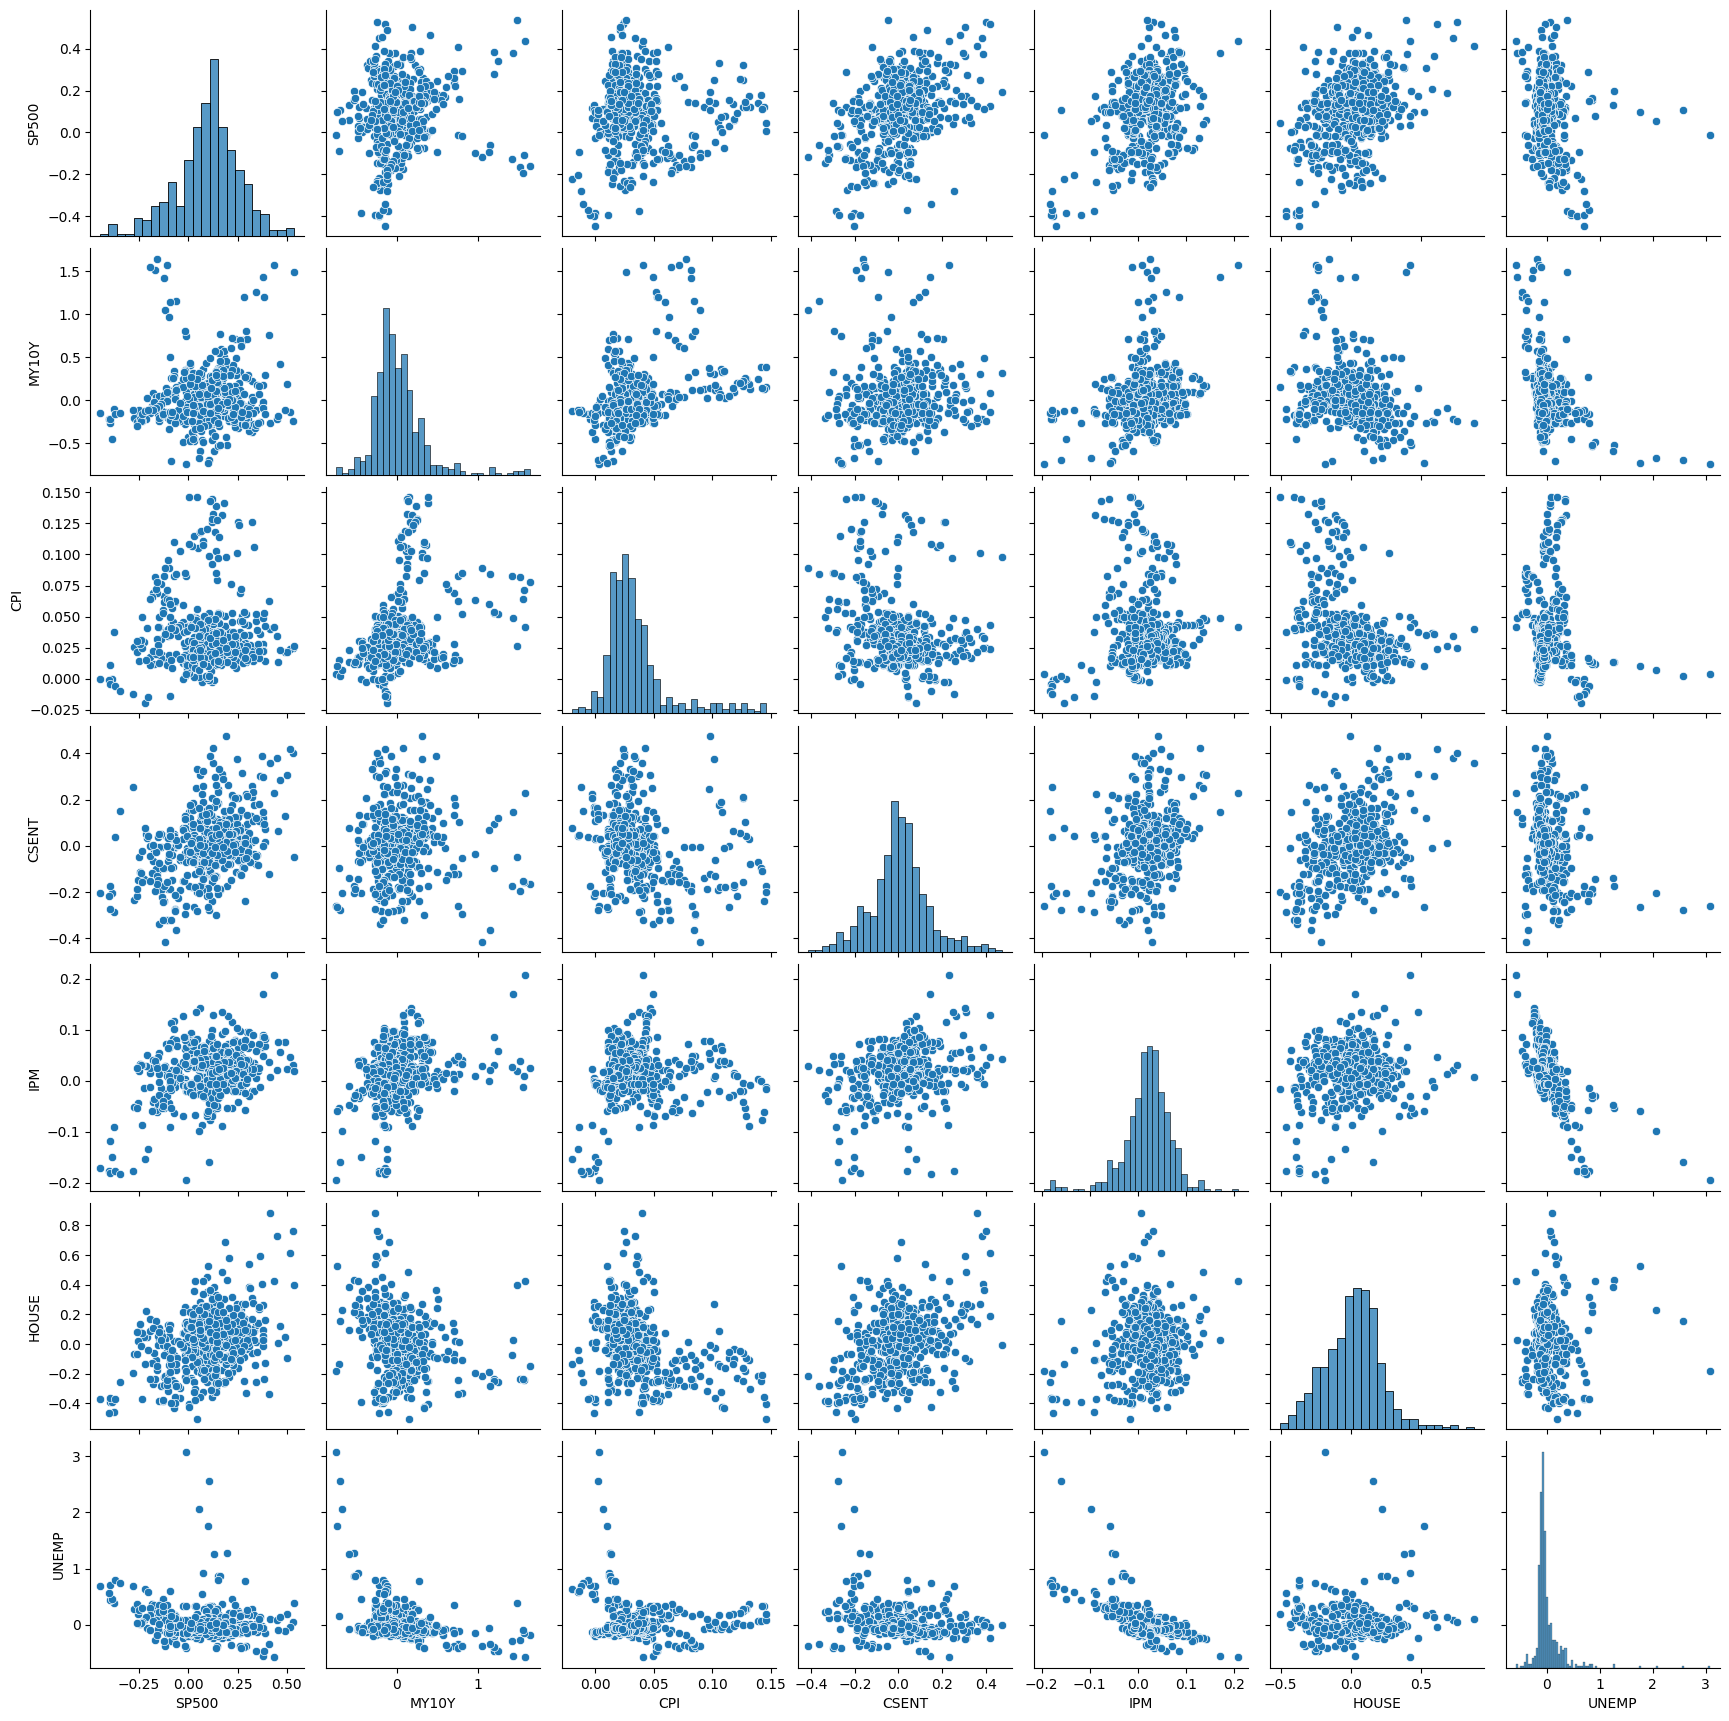

In [17]:
# check correlation 
sns.pairplot(df[num_cols])

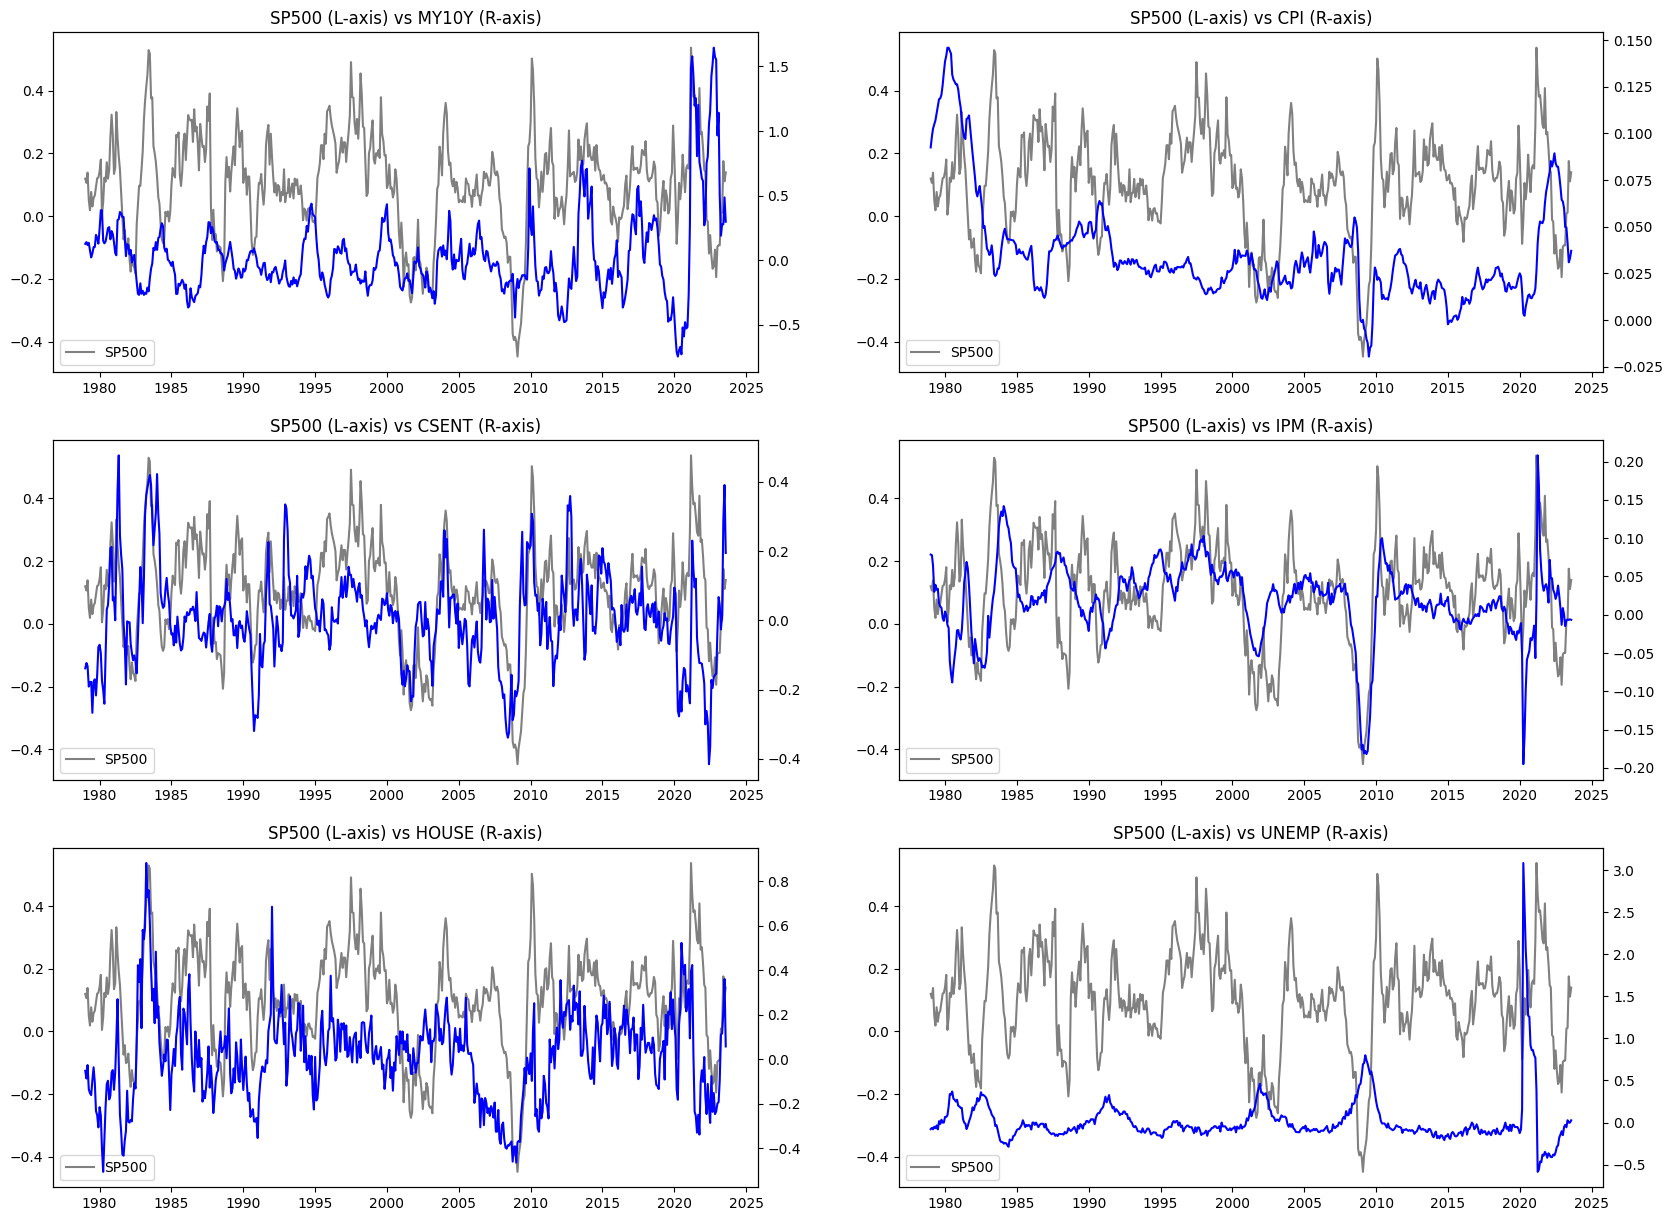

In [27]:
# Observing the relationships between S&P500 idex and economic indicators
rows, cols = 3, 2
#['MY10Y', 'CPI', 'CSENT', 'IPM', 'HOUSE', 'UNEMP']

fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 15))

for idx, d in enumerate(num_cols[1:]):
    i, j = idx // cols, idx % cols
    # plot two line charts
    ax[i][j].plot(pd.to_datetime(df['Date']), df['SP500'], color='grey', label='SP500')
    ax[i][j].twinx().plot(pd.to_datetime(df['Date']), df[d], color='blue', label=d)
    ax[i][j].set_title(f"SP500 (L-axis) vs {d} (R-axis)")
    ax[i][j].legend()


# Dataset Creation

- All data except for 'UNEMP' are converted to %YoY. 
- There are 12 datasets derived from the original one.
    - Three types of future performances (row shifts) will be applied to all economic indicators; 1-, 2-, and 3-months
    - Four types of moving averages will be applied to every data; 0-, 3-, 6-, and 12-months

In [ ]:
# create dictionary of dataframe
df_dict = {}
# define column names for each x and y from "df"
col_Y = 'SP500_%YoY'
col_X = ['MY10Y_%YoY', 'CPI_%YoY', 'CSENT_%YoY', 'IPM_%YoY', 'HOUSE_%YoY', 'UNEMP']

# row shifts
for s in [1,2,3]:
    # copy current df
    new_df = df.copy()
    # shifting row(s)
    new_df = new_df[col_X].shift(s)

    # different moving average
    for ma in [0, 3, 6, 12]:
        pass

In [ ]:
focus_cols.remove('SP500_%YoY')
focus_cols

['MY10Y_%YoY', 'CPI_%YoY', 'CSENT_%YoY', 'IPM_%YoY', 'HOUSE_%YoY', 'UNEMP']

In [ ]:
test = df[['MY10Y_%YoY', 'CPI_%YoY', 'CSENT_%YoY', 'IPM_%YoY', 'HOUSE_%YoY', 'UNEMP']].shift(1)

test

,MY10Y_%YoY,CPI_%YoY,CSENT_%YoY,IPM_%YoY,HOUSE_%YoY,UNEMP
0,NaN,NaN,NaN,NaN,NaN,NaN
1,0.072973,0.068143,-0.037931,0.068292,-0.036364,6.4
2,0.079195,0.062395,-0.032147,0.052995,-0.057211,6.3
3,0.098383,0.063758,-0.095293,0.056017,-0.066514,6.3
4,0.106040,0.065000,-0.063146,0.061632,0.081352,6.1
...,...,...,...,...,...,...
543,0.500000,0.049869,0.043771,-0.014847,-0.094767,3.5
544,0.190311,0.049572,-0.026074,-0.007125,0.111293,3.4
545,0.277193,0.041288,0.013699,-0.006166,0.116352,3.7
546,0.278523,0.030920,0.288000,-0.006616,0.214920,3.6


# Model Creation

# Test

In [ ]:
x_cols = ['MY10Y', 'CPI', 'CSENT', 'IPM', 'HOUSE', 'UNEMP']

In [ ]:

from sklearn.linear_model import LinearRegression

model = LinearRegression()
# fit the data
model.fit(df[x_cols][-240:-120], df['SP500'][-240:-120])
# get predicted variables
Y_hat = model.predict(df[x_cols][-120:])
# show the first 5 result
print(Y_hat)

[ 0.17198582  0.12924194  0.15618108  0.23215706  0.11040081  0.10907041
  0.13358637  0.19426825  0.07323447  0.0275044   0.06944946  0.04041252
  0.09338101  0.10748909  0.08915687  0.05836864  0.0782465   0.05697373
  0.02090388  0.03783092  0.0242238   0.05364562  0.03960915  0.03746019
 -0.051951   -0.01922398 -0.00516259 -0.01731165 -0.01027703 -0.04788539
 -0.01525134 -0.0339602  -0.0042887  -0.05544431 -0.06136277 -0.05283349
  0.02753661  0.00848339  0.06661682  0.08700139  0.14863859  0.16194002
  0.1507502   0.14700114  0.11733177  0.1661117   0.15476931  0.14013791
  0.16028338  0.1897907   0.11838548  0.05280172  0.04969984  0.13441906
  0.1370119   0.14593948  0.11979971  0.14624847  0.17236289  0.16020811
  0.1581428   0.09961317  0.07446773  0.08269742  0.02588854 -0.02461746
 -0.01913762 -0.04712457 -0.04048557 -0.04930296 -0.06545531 -0.10568811
 -0.12174191 -0.10466448 -0.07237729 -0.03136956 -0.02474858 -0.05086117
 -0.24229386 -0.16271072 -0.1366001  -0.03712655 -0

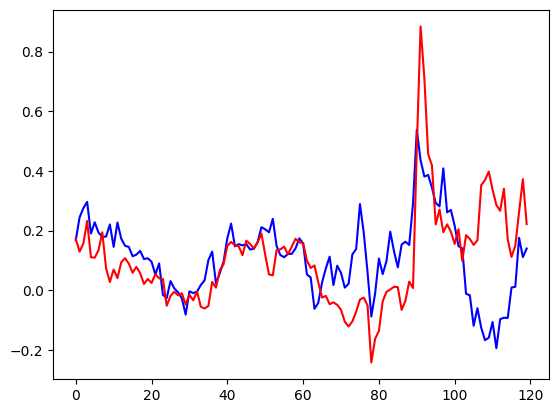

In [ ]:
plt.plot(df['SP500'][-120:].values, color='blue')
plt.plot(Y_hat, color='red')

In [ ]:
df['SP500'][:-120]

12     0.119664
13     0.106158
14     0.138774
15     0.050914
16     0.018922
         ...   
423    0.142827
424    0.244526
425    0.179215
426    0.222146
427    0.160951
Name: SP500, Length: 416, dtype: float64